* Importing Libraries

In [1]:
import numpy as np                      # For numpy operatios
import pandas as pd                     # For data structure operations
import matplotlib.pyplot as plt         # For plottingoperations
import seaborn as sb                    # For visualization operations

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler  # For preprocessing of data

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import DBSCAN, KMeans,AgglomerativeClustering  # Importing the clustering algorithms

from sklearn.metrics import silhouette_score      # For calculting silhouette score of clustering models
from sklearn.neighbors import NearestNeighbors    # For plotting the K-distance graph
import scipy.cluster.hierarchy as sch             # For plotting the Dendogram for Agglomerative Clustering

import warnings
warnings.filterwarnings('ignore')      # Ignoring the filter warnings

* Data Reading & Exploration

In [2]:
#reading the data
mall_c=pd.read_csv('DS3_C6_S3_MallCustomers_Data_Project.csv')
mall=mall_c.copy()
mall.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# shape of data
mall.shape

(200, 5)

In [4]:
# to check the data types of each column
mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# checking the null values
mall.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
# statistical measurements
mall.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
# checking the value counts of each attributes of each categorical columns
mall['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

* EDA

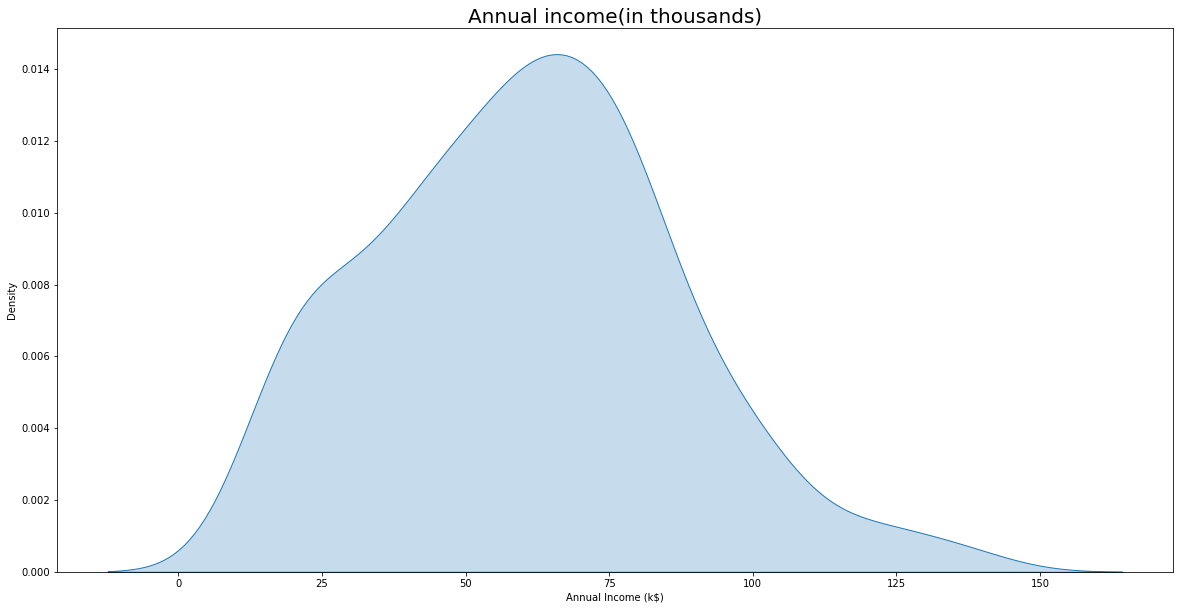

In [8]:
#Spread of the annual income of all customers
plt.figure(figsize=(20,10))
plt.title('Annual income(in thousands)', fontsize=20)
sb.kdeplot(data=mall, x='Annual Income (k$)', shade=True);

* Most of the customers have Annual Income of 30k - 80k

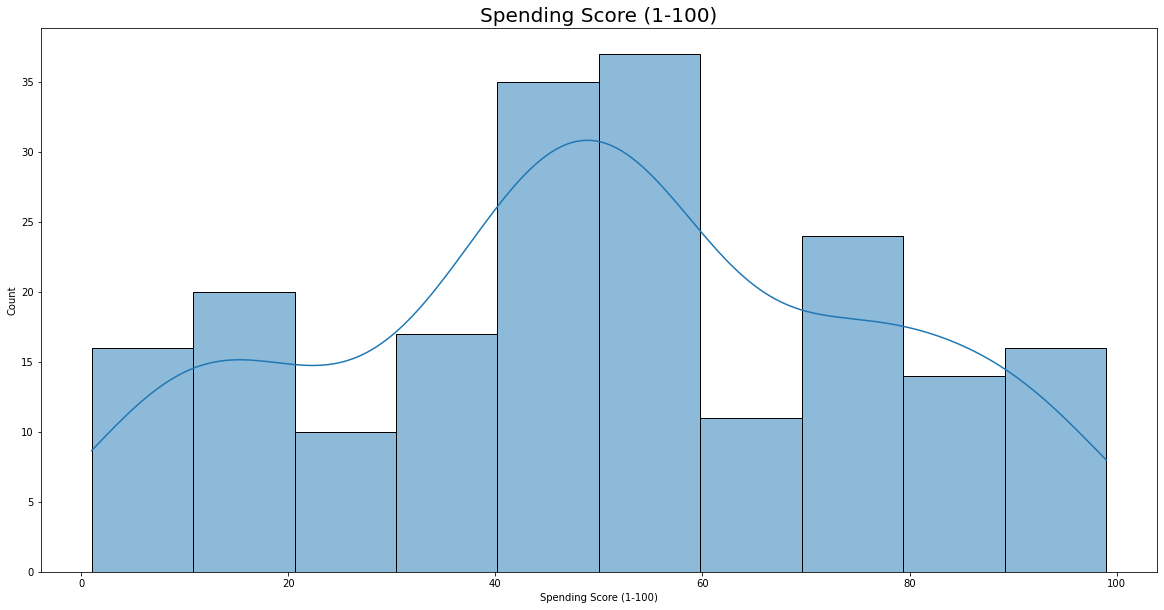

In [9]:
#Spread of the spending score of all customers
plt.figure(figsize=(20,10))
plt.title('Spending Score (1-100)', fontsize=20)
sb.histplot(data=mall, x='Spending Score (1-100)', bins=10,kde=True);

* Most of the customers spend their score ranging 30-60

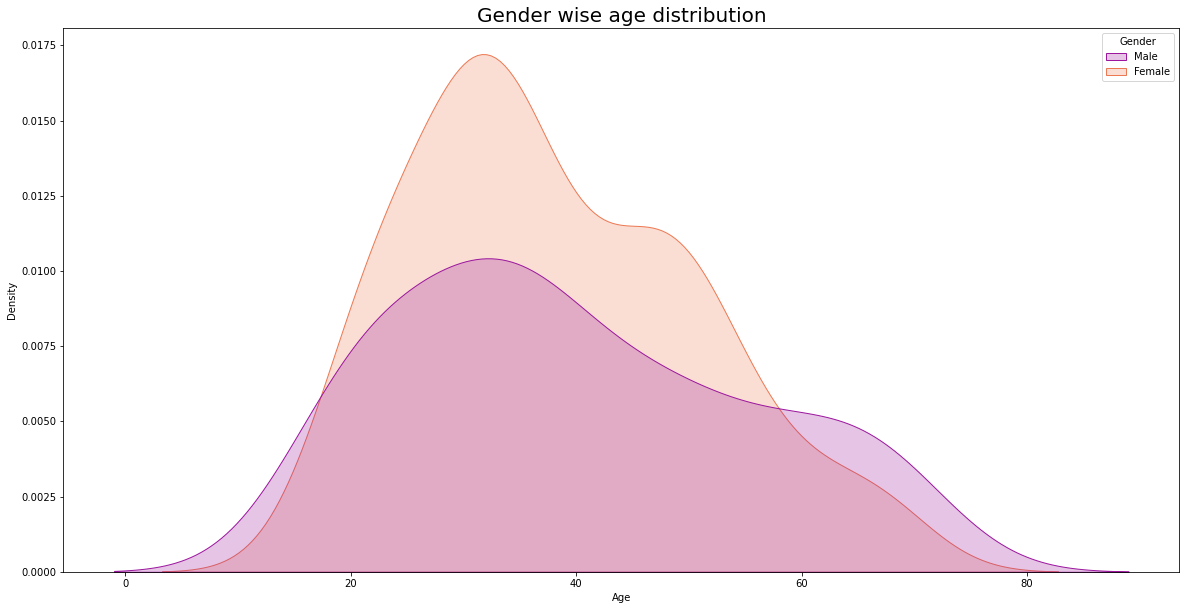

In [10]:
# Gender wise Age distibution 
plt.figure(figsize=(20,10))
plt.title('Gender wise age distribution', fontsize=20)
sb.kdeplot(data=mall, x='Age',hue='Gender', shade=True,palette='plasma');

* Most of the female & male customers are of 30-55 age.

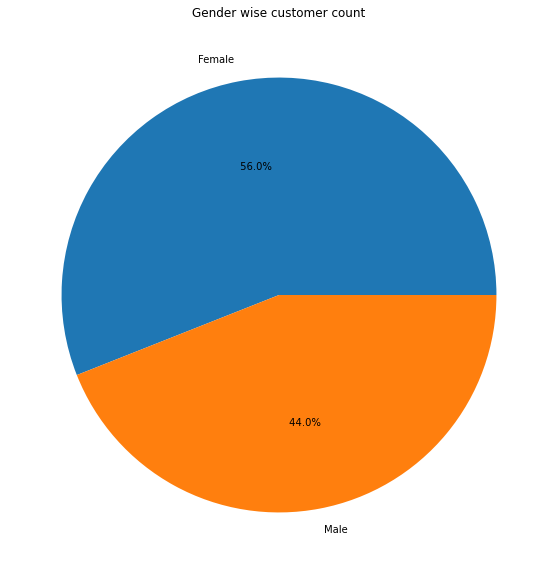

In [11]:
# Gender wise customer count
d=mall['Gender'].value_counts()
lbl=d.index
plt.figure(figsize=(10,10))
plt.title('Gender wise customer count')
plt.pie(x=d, labels=lbl, autopct='% .1f%%')
plt.show()

* There are more female customers(56%) present compared to male customers(44%).

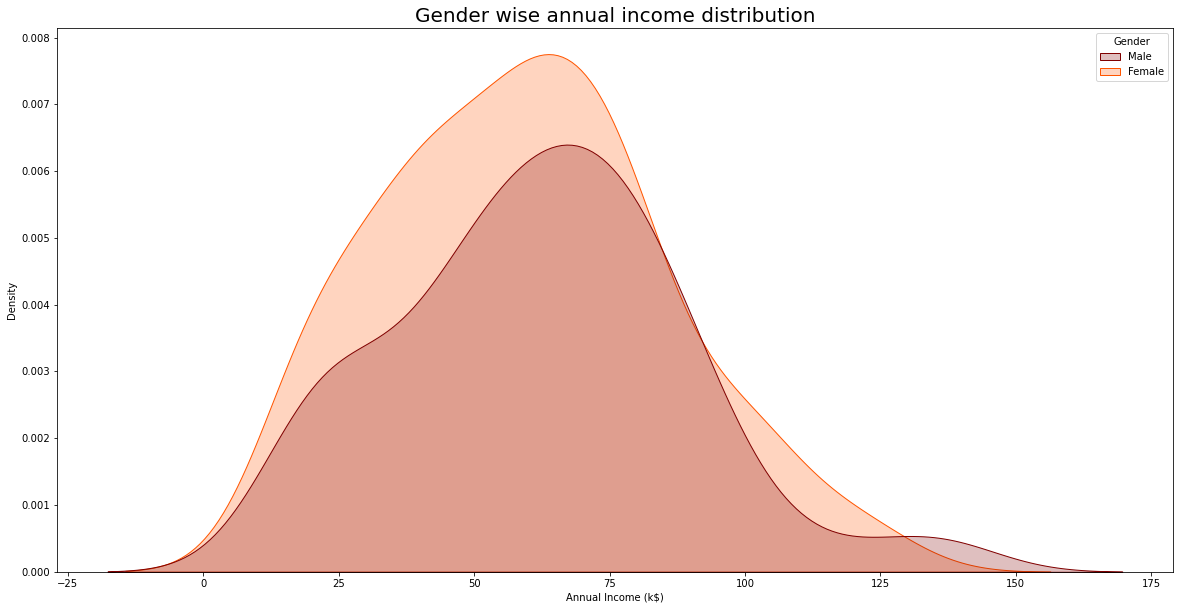

In [12]:
# Gender wise annual income distribution
plt.figure(figsize=(20,10))
plt.title('Gender wise annual income distribution', fontsize=20)
sb.kdeplot(data=mall, x='Annual Income (k$)',hue='Gender', shade=True,palette='gist_heat');

* Male customers earn slightly more than female customers.

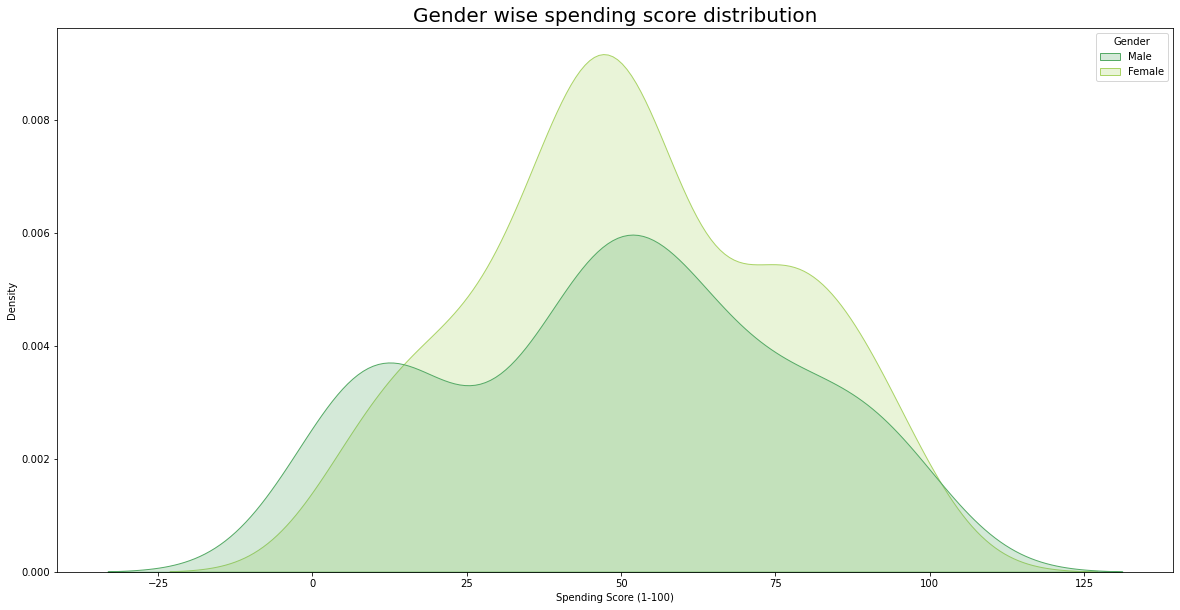

In [13]:
# Gender wise spending score distribution
plt.figure(figsize=(20,10))
plt.title('Gender wise spending score distribution', fontsize=20)
sb.kdeplot(data=mall, x='Spending Score (1-100)',hue='Gender', shade=True,palette='summer');

* Female customers spend more scores than male customers.

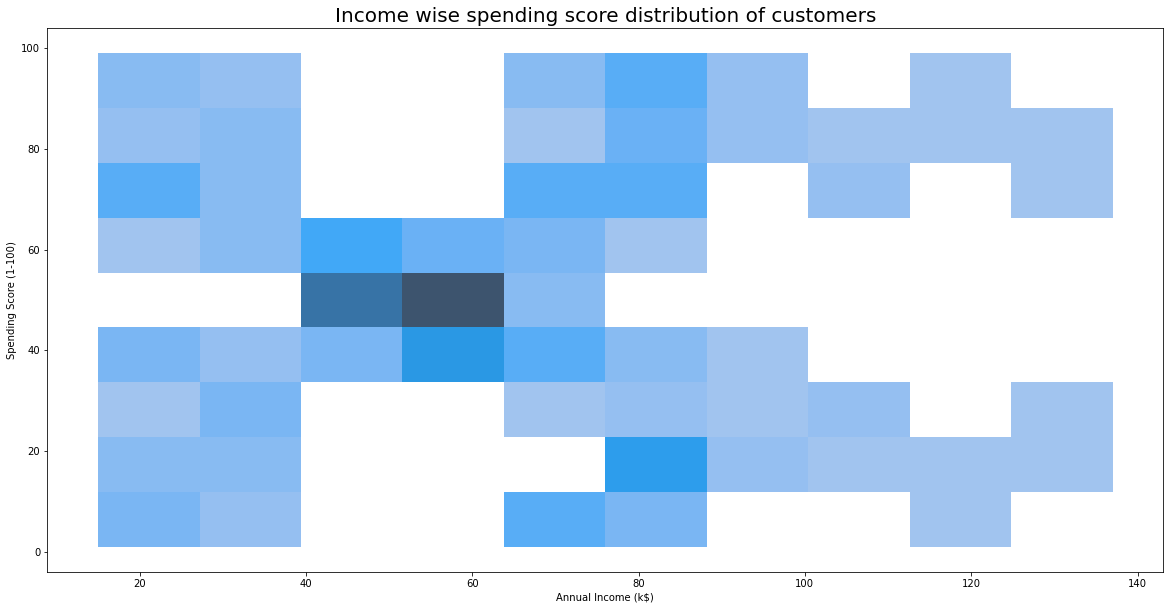

In [14]:
# Income wise score distribution of 
plt.figure(figsize=(20,10))
plt.title('Income wise spending score distribution of customers', fontsize=20)
sb.histplot(data=mall, y='Spending Score (1-100)',x='Annual Income (k$)');

* Target those customers who earns more & spend more also. They are the ideal one to spend more on festive season sales.
* Consider those customers who earns moderate & spend moderate also. Their is a chance that they can spend a bit more on the festive season sales.
* You can Consider those customers also who earns more but spend less. Their is a chance that they can spend a bit more on the festive season sales.
* Avoid the customers who earns less but spends more cause their is always a risk that they use their credit cards to pay the bills.
* Avoid the customers who earns less but spends less also.

* Data preprocessing & data mining

In [15]:
#lable encoding the categorical columns
lable_encoder=LabelEncoder()
mall['Gender_Encoder']=lable_encoder.fit_transform(mall['Gender'])
mall.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Gender_Encoder
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


In [16]:
# Dropping age and Customer id cause we don't required them
mall.drop(['CustomerID','Age'], axis=1, inplace=True)
#taking the numerical rows
mall_num= mall.select_dtypes(include=[np.number])
mall_num.head()

,Annual Income (k$),Spending Score (1-100),Gender_Encoder
0,15,39,1
1,15,81,1
2,16,6,0
3,16,77,0
4,17,40,0


## K-Means Algorithm

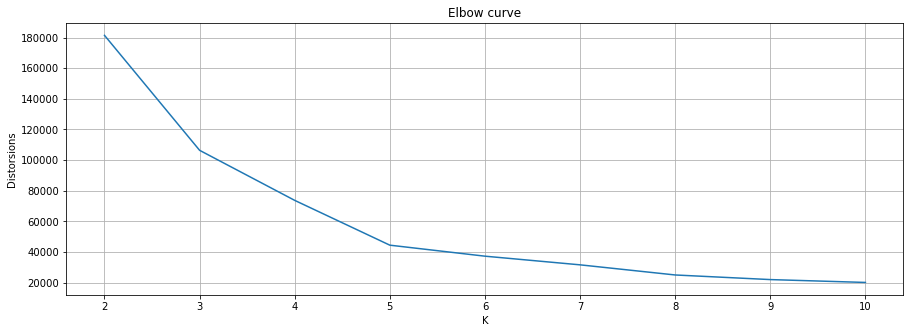

In [17]:
distortion=[]                               # empty list to append the distortions
for i in range(2,11):
    km=KMeans(n_clusters=i, random_state=1) # building the model & checking at what cluster we got the elbow of the curve
    km.fit(mall_num)                        # Fitting my data into the model
    distortion.append(km.inertia_)          # Appending the distortions
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), distortion)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Distorsions')
plt.title('Elbow curve');

In [18]:
for i in range(2,11):
    km=KMeans(n_clusters=i, random_state=1)      #build my model 
    cluster=km.fit_predict(mall_num)             # fitting and predicting my data
    sil=silhouette_score(mall_num,cluster)       # calculate the silhouette score
    print('Cluster ',i ,': Silhouette score : ',sil)  # checking at what cluster i will get the best silhoutte score
    print(10*'=======')

Cluster  2 : Silhouette score :  0.29671202995203916
Cluster  3 : Silhouette score :  0.46733000902034116
Cluster  4 : Silhouette score :  0.49281793644822175
Cluster  5 : Silhouette score :  0.5534496268497305
Cluster  6 : Silhouette score :  0.5374223124239517
Cluster  7 : Silhouette score :  0.45292400989869824
Cluster  8 : Silhouette score :  0.45427650522327084
Cluster  9 : Silhouette score :  0.45210361224756196
Cluster  10 : Silhouette score :  0.44517823127643624


In [19]:
kmean=KMeans(n_clusters=5, random_state=1)            # Build my model with desired cluster number
x_km=mall_num.iloc[:,[0,1]].values                    # taking only 2 columns for further progress
y_km=kmean.fit_predict(x_km)                          # fitting and predicting my data
sil_km=silhouette_score(x_km,y_km)                    # Calculating the silhouette score
mall['Cluster(KMean)']=y_km                           # adding a new dataframe with cluster number getting from k means algorithm
print('Silhouette Score of Kmeans Algorithm : ',sil_km)
mall.head()

Silhouette Score of Kmeans Algorithm :  0.553931997444648


,Gender,Annual Income (k$),Spending Score (1-100),Gender_Encoder,Cluster(KMean)
0,Male,15,39,1,4
1,Male,15,81,1,0
2,Female,16,6,0,4
3,Female,16,77,0,0
4,Female,17,40,0,4


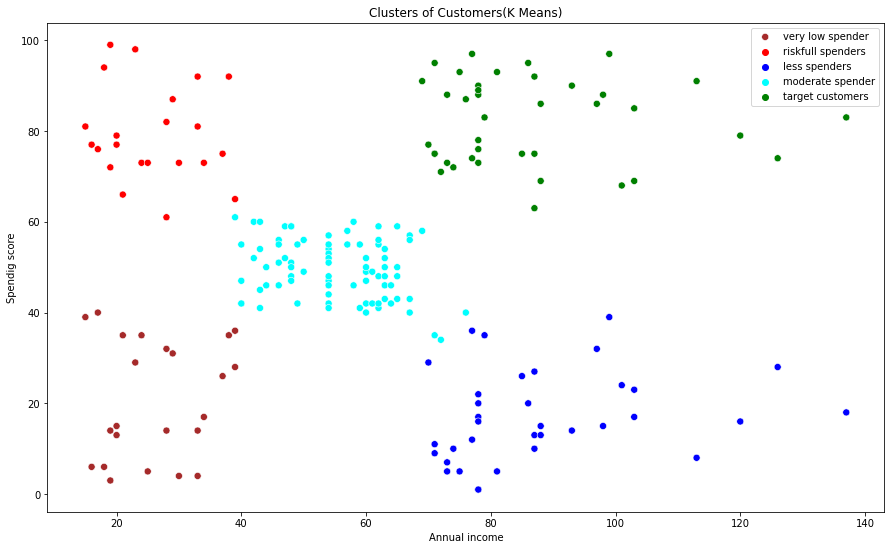

In [20]:
# Plotting the scatterplot of K means clustering
plt.figure(figsize=(15,9))
plt.title('Clusters of Customers(K Means)')
plt.xlabel("Annual income")
plt.ylabel("Spendig score")
sample_colours=['red','blue','cyan','green','brown']
sb.scatterplot(data=mall_num, x=x_km[:,0], y=x_km[:,1], hue=y_km,s=50,palette=sample_colours)
plt.legend(labels=['very low spender','riskfull spenders','less spenders','moderate spender','target customers']);

### The clusters are clearly seperable and also intepretable here
* Target those customers who earns more & spend more also. They are the ideal one to spend more on festive season sales.
* Consider those customers who earns moderate & spend moderate also. Their is a chance that they can spend a bit more on the festive season sales.
* You can Consider those customers also who earns more but spend less. Their is a chance that they can spend a bit more on the festive season sales.
* Avoid the customers who earns less but spends more cause their is always a risk that they use their credit cards to pay the bills.
* Avoid the customers who earns less but spends less also.

## Agglomerative Clustering

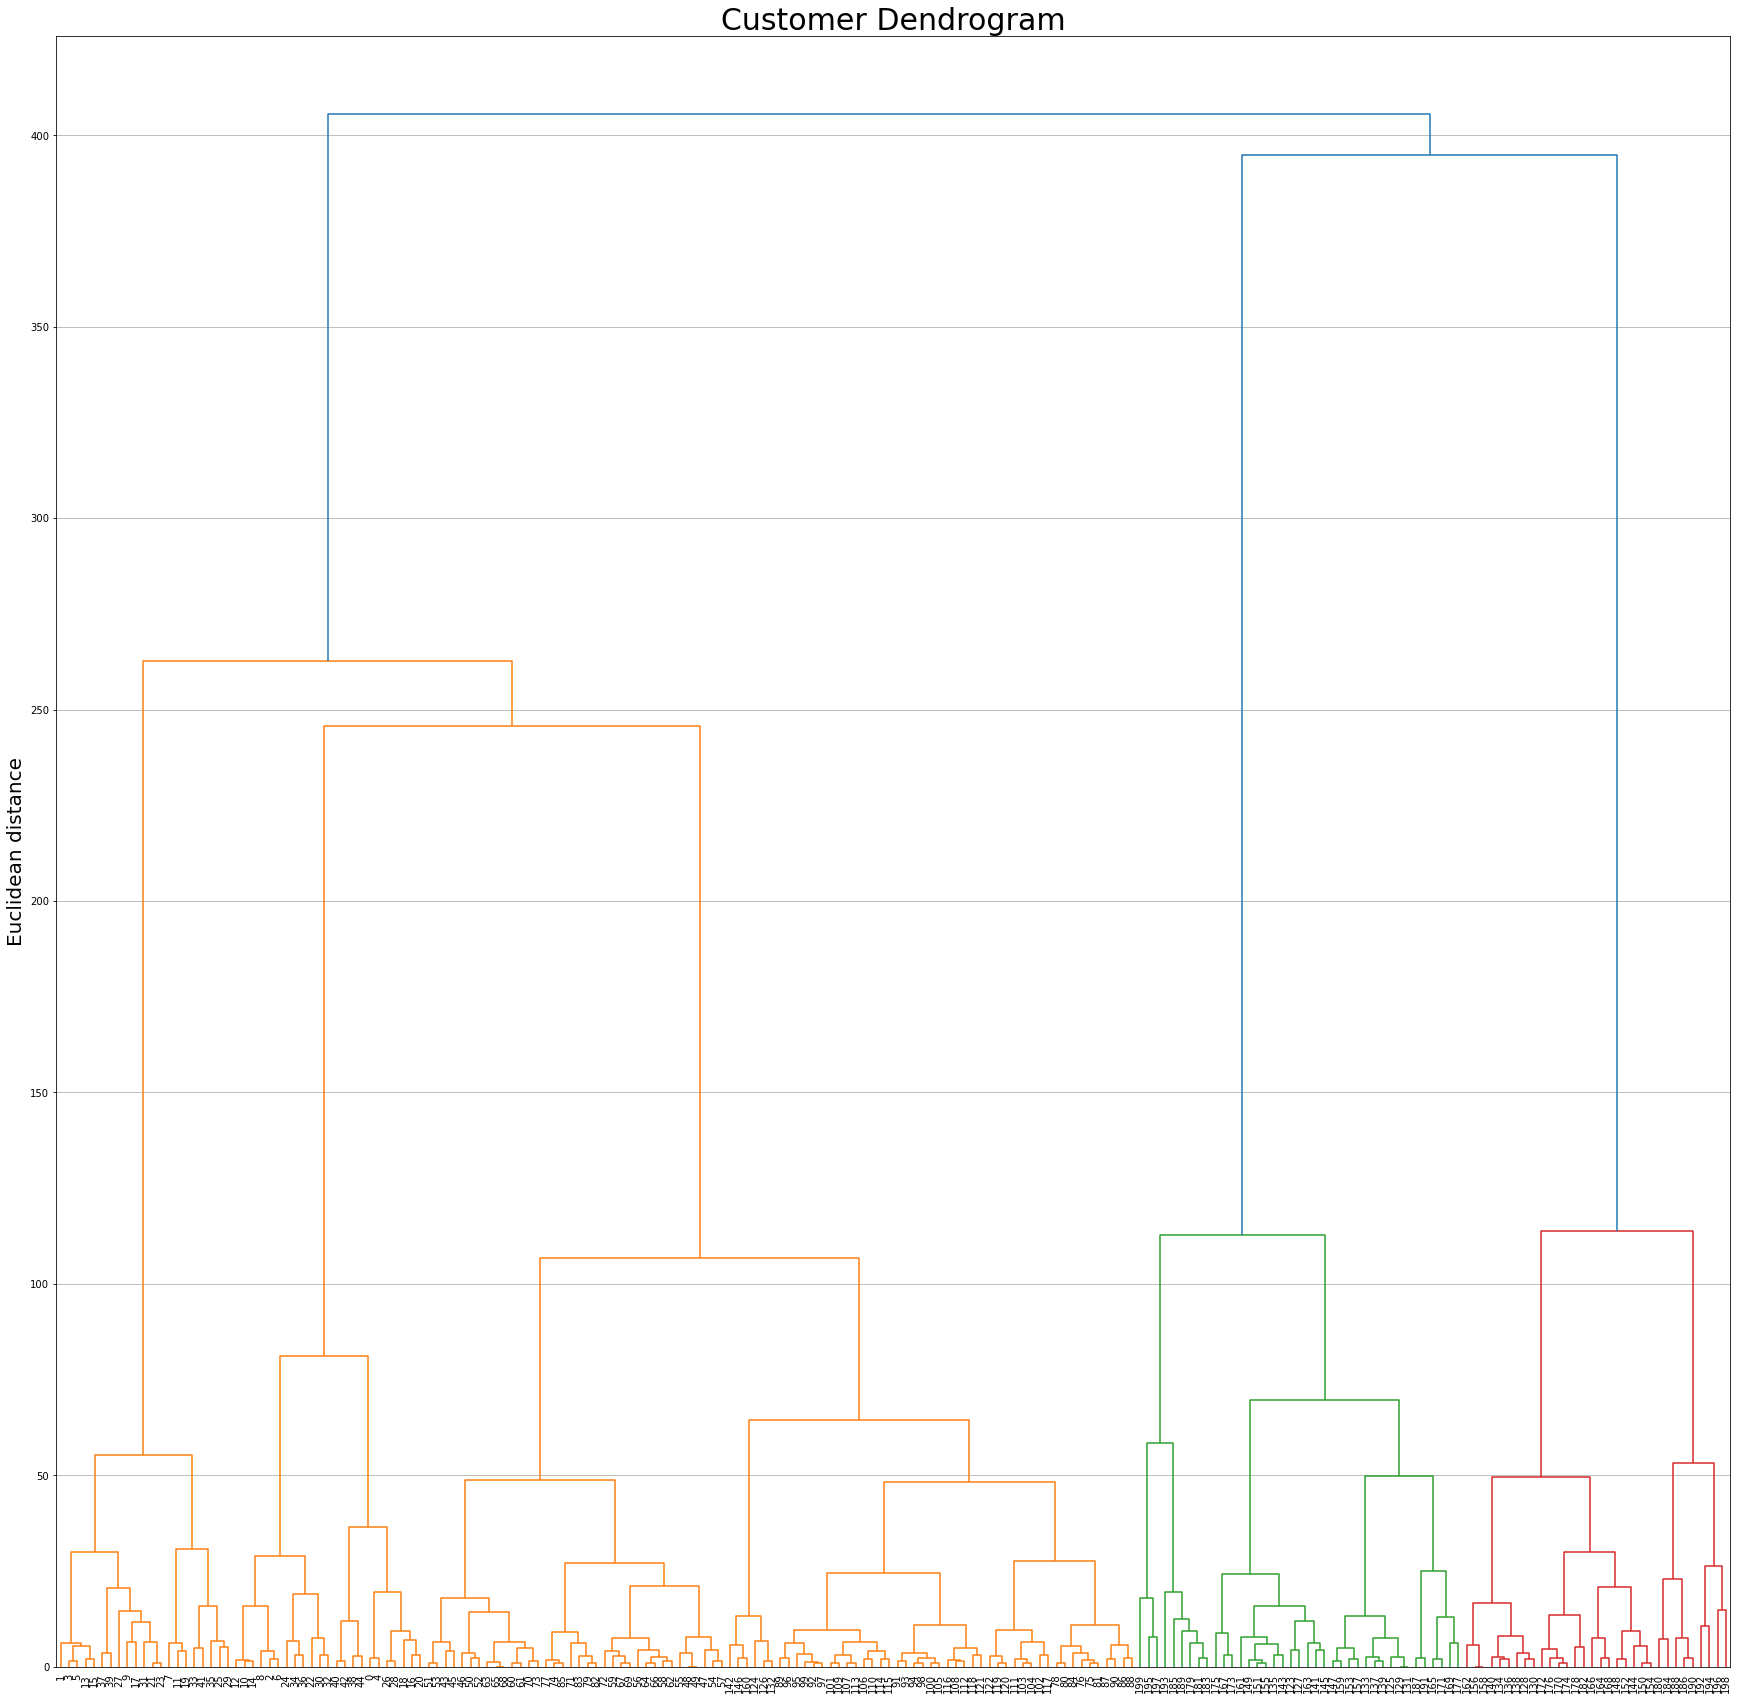

In [21]:
# creating a dendrogram (method= ward)
plt.figure(figsize=(30, 30))
dendrogrm = sch.dendrogram(sch.linkage(x_km, method = 'ward'),labels=mall_num.index,orientation='top')  # setting paremetrs to plot the dendogram
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.grid(True,axis='y',which='both')
plt.title('Customer Dendrogram',fontsize=30)
plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

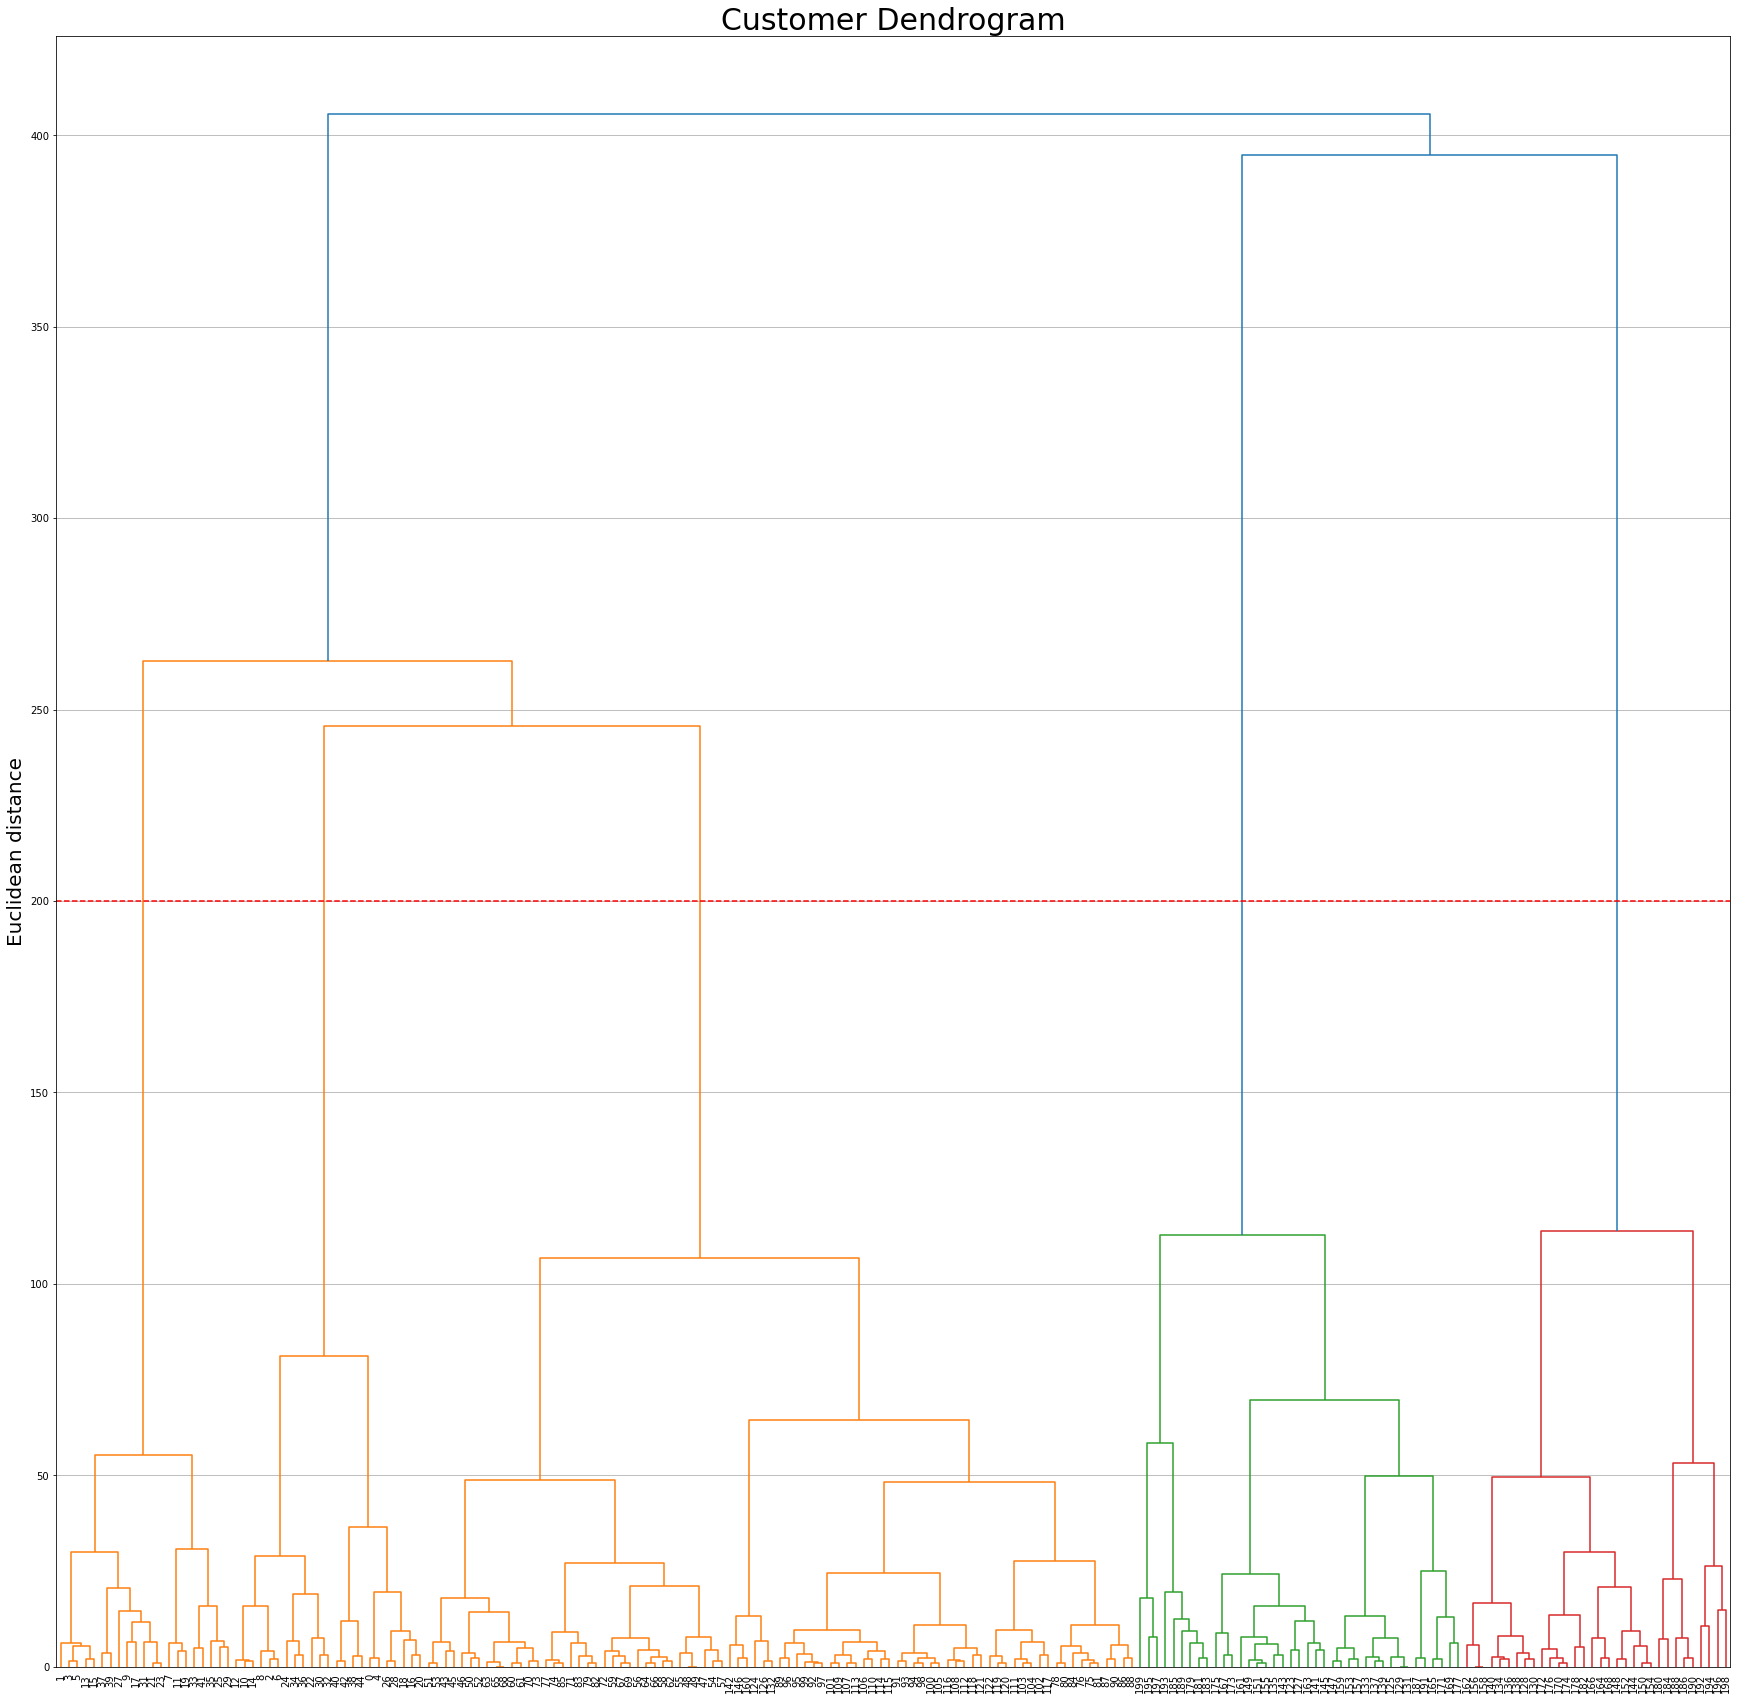

In [22]:
# creating a dendrogram (method= ward)
plt.figure(figsize=(30, 30))
dendrogrm = sch.dendrogram(sch.linkage(x_km, method = 'ward'),labels=mall_num.index,orientation='top')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.grid(True,axis='y',which='both')
plt.axhline(y=200, color='r', linestyle='--')       # finding the required cluster number from the dendogram plot
plt.title('Customer Dendrogram',fontsize=30)
plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

In [23]:
agl= AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward') # build my model with obtained no of clusters from dendogram
y_agl=agl.fit_predict(x_km)                                                      # Fitting and predicting my data
sil_agl=silhouette_score(x_km,y_agl)                                             # calculate the silhouette score of my model
mall['Cluster(AGL)']=y_agl                                                       # add a new column with agglomerative clustering values
print('Silhouette Score of Hierarchy Algorithm : ',sil_agl)
mall.head()

Silhouette Score of Hierarchy Algorithm :  0.5529945955148897


,Gender,Annual Income (k$),Spending Score (1-100),Gender_Encoder,Cluster(KMean),Cluster(AGL)
0,Male,15,39,1,4,4
1,Male,15,81,1,0,3
2,Female,16,6,0,4,4
3,Female,16,77,0,0,3
4,Female,17,40,0,4,4


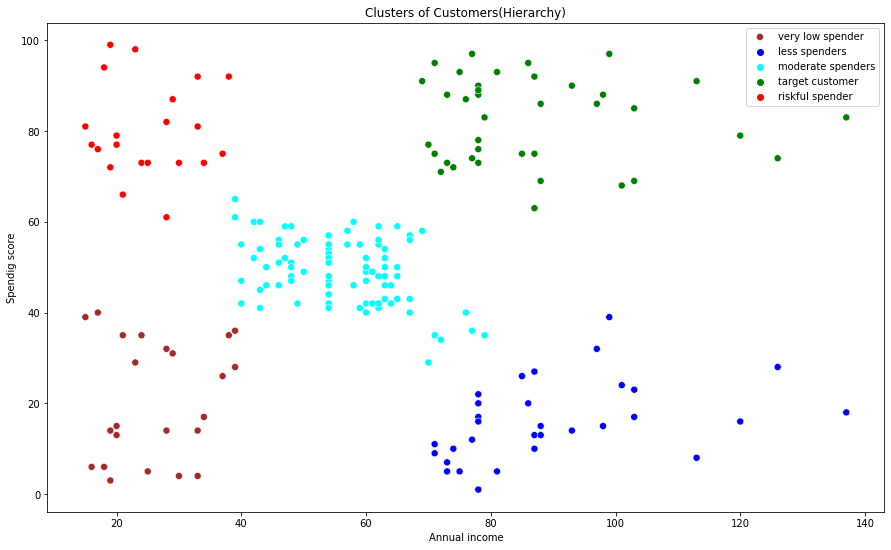

In [24]:
# plotting the scatter plot of agglomerative clustering
plt.figure(figsize=(15,9))
plt.title('Clusters of Customers(Hierarchy)')
plt.xlabel("Annual income")
plt.ylabel("Spendig score")
sample_colours=['blue','cyan','green','red','brown']
sb.scatterplot(data=mall_num, x=x_km[:,0], y=x_km[:,1], hue=y_agl,s=50,palette=sample_colours)
plt.legend(labels=['very low spender','less spenders','moderate spenders','target customer','riskful spender']);

### The clusters are clearly seperable and also intepretable here
* Target those customers who earns more & spend more also. They are the ideal one to spend more on festive season sales.
* Consider those customers who earns moderate & spend moderate also. Their is a chance that they can spend a bit more on the festive season sales.
* You can Consider those customers also who earns more but spend less. Their is a chance that they can spend a bit more on the festive season sales.
* Avoid the customers who earns less but spends more cause their is always a risk that they use their credit cards to pay the bills.
* Avoid the customers who earns less but spends less also.

## DBSCAN algorithm (Density Based Spiral Clustering Application with noise)

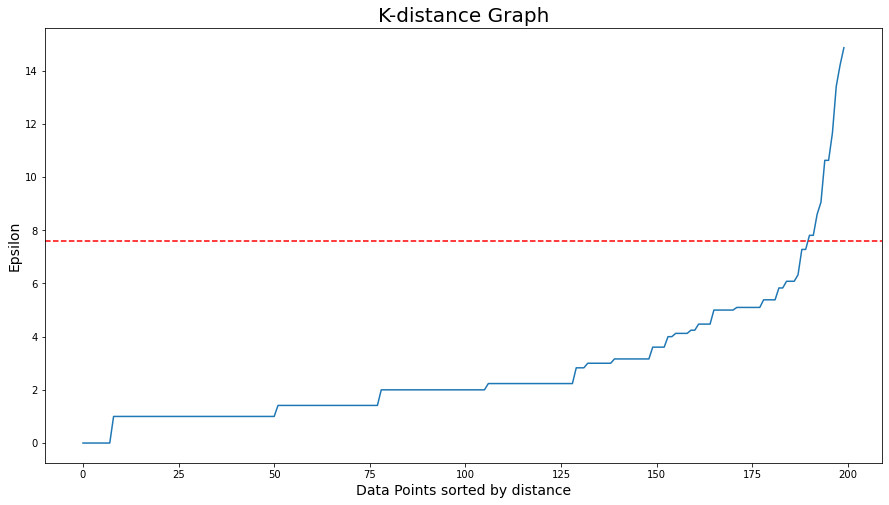

In [25]:
 # getting the optimal epsilon value.
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(x_km)
distances, indices = nbrs.kneighbors(x_km)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(15,8))
plt.plot(distances)
plt.axhline(y=7.6, color='r', linestyle='--')
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [26]:
eps=7.6
for min_samples in list(range(2,15)):
    db = DBSCAN(eps=eps, min_samples=min_samples)    # Building my model with optimum epsilon value and cheking at which sample we are getting the best result
    y_db = db.fit_predict(x_km)                      # fitting and predicting my data
    
   
    sil_db=silhouette_score(x_km,y_db)               # calculating the silhouette score of each sampling
    
    x= y_db +2
    y = np.bincount(x)
    ii = np.nonzero(y)[0]
    results = list(zip(ii,y[ii]) )                    # getting the sample sizes
    print('eps=',eps,'| min_samples= ', min_samples, '| obtained clustering: ', results)
    print("silhouette_score: ", sil_db)
    print("====================================================")

eps= 7.6 | min_samples=  2 | obtained clustering:  [(1, 10), (2, 7), (3, 17), (4, 9), (5, 3), (6, 3), (7, 89), (8, 32), (9, 14), (10, 12), (11, 2), (12, 2)]
silhouette_score:  0.374793348539216
eps= 7.6 | min_samples=  3 | obtained clustering:  [(1, 14), (2, 7), (3, 17), (4, 9), (5, 3), (6, 3), (7, 89), (8, 32), (9, 14), (10, 12)]
silhouette_score:  0.4134368438495633
eps= 7.6 | min_samples=  4 | obtained clustering:  [(1, 23), (2, 16), (3, 8), (4, 7), (5, 88), (6, 32), (7, 14), (8, 9), (9, 3)]
silhouette_score:  0.3841266254586625
eps= 7.6 | min_samples=  5 | obtained clustering:  [(1, 35), (2, 12), (3, 5), (4, 7), (5, 88), (6, 30), (7, 14), (8, 9)]
silhouette_score:  0.31595469080938154
eps= 7.6 | min_samples=  6 | obtained clustering:  [(1, 56), (2, 10), (3, 87), (4, 24), (5, 14), (6, 9)]
silhouette_score:  0.25563518382451894
eps= 7.6 | min_samples=  7 | obtained clustering:  [(1, 73), (2, 9), (3, 82), (4, 12), (5, 24)]
silhouette_score:  0.22577152041484733
eps= 7.6 | min_samples=

In [27]:
db=DBSCAN(eps=7.6,min_samples=7)    # building my model with optimum epsilon and min sample values
y_db=db.fit_predict(x_km)           # Fitting and predicting my data
sil_db=silhouette_score(x_km,y_db)  # calculating the silhouette score of my model
mall['Cluster(DBSCAN)']=y_db        # adding a column with obtained cluster values from dbscan
print('Silhouette Score of DBSCAN Algorithm : ',sil_db)
mall.head()

Silhouette Score of DBSCAN Algorithm :  0.22577152041484733


,Gender,Annual Income (k$),Spending Score (1-100),Gender_Encoder,Cluster(KMean),Cluster(AGL),Cluster(DBSCAN)
0,Male,15,39,1,4,4,-1
1,Male,15,81,1,0,3,0
2,Female,16,6,0,4,4,-1
3,Female,16,77,0,0,3,0
4,Female,17,40,0,4,4,-1


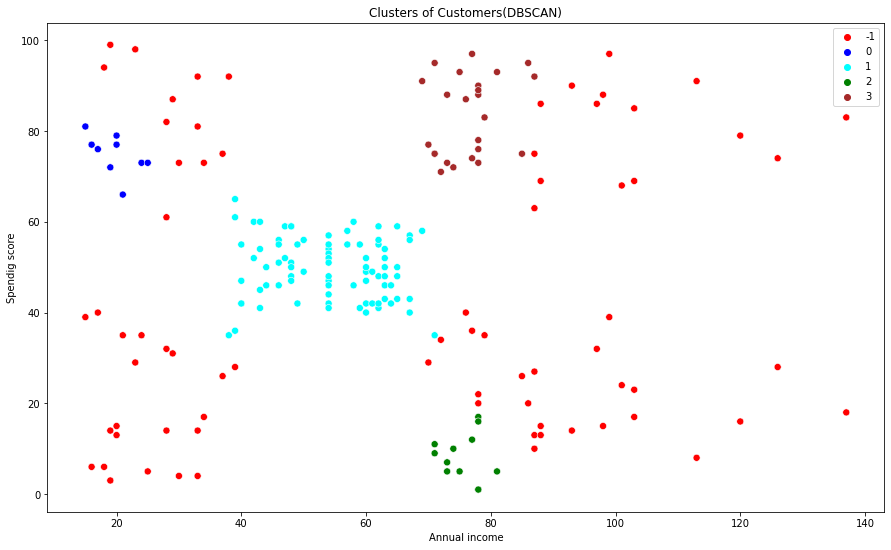

In [28]:
# plotting the scatterplot of dbscan algorithm
plt.figure(figsize=(15,9))
plt.title('Clusters of Customers(DBSCAN)')
plt.xlabel("Annual income")
plt.ylabel("Spendig score")
sample_colours=['red','blue','cyan','green','brown']
sb.scatterplot(data=mall_num, x=x_km[:,0], y=x_km[:,1], hue=y_db,s=50,palette=sample_colours);

### The clusters are not seperable & interpretable and their is a noise coming also. So we can avoid this algorithm.

* Final Summary of all models

In [29]:
tbl=pd.DataFrame()
tbl['Model']=pd.Series(['K-Means','Aglomerative','DBSCAN'])
tbl['Silhouette Score']=pd.Series([sil_km,sil_agl,sil_db])
tbl.set_index('Model')

,Silhouette Score
Model,
K-Means,0.553932
Aglomerative,0.552995
DBSCAN,0.225772


### According to silhouette score and scatter plot we can conclude that K-Mean model is appropriate for this dataset to predict further datas.

* Using K-Means Clustering to label the numerical clusters

In [30]:
# giving name to the K-Mean clusters 
def fill_null(mall,i):
    if mall['Cluster(KMean)'][i]== 0:
        return 'Riskfull Spenders'
    elif mall['Cluster(KMean)'][i]==1:
        return 'Less Spenders'
    elif mall['Cluster(KMean)'][i]==2:
        return 'Moderate Spender'
    elif mall['Cluster(KMean)'][i]==3:
        return 'Target Customers'
    else:
        return 'Very Low Spenders'
lst=['Very Low Spenders','Riskfull Spenders','Less Spenders','Moderate Spender','Target Customers']
for i in range(0,len(mall)):
    if mall['Cluster(KMean)'][i] not in lst:
        mall['Cluster(KMean)'][i]= fill_null(mall,i)
mall.head()

,Gender,Annual Income (k$),Spending Score (1-100),Gender_Encoder,Cluster(KMean),Cluster(AGL),Cluster(DBSCAN)
0,Male,15,39,1,Very Low Spenders,4,-1
1,Male,15,81,1,Riskfull Spenders,3,0
2,Female,16,6,0,Very Low Spenders,4,-1
3,Female,16,77,0,Riskfull Spenders,3,0
4,Female,17,40,0,Very Low Spenders,4,-1


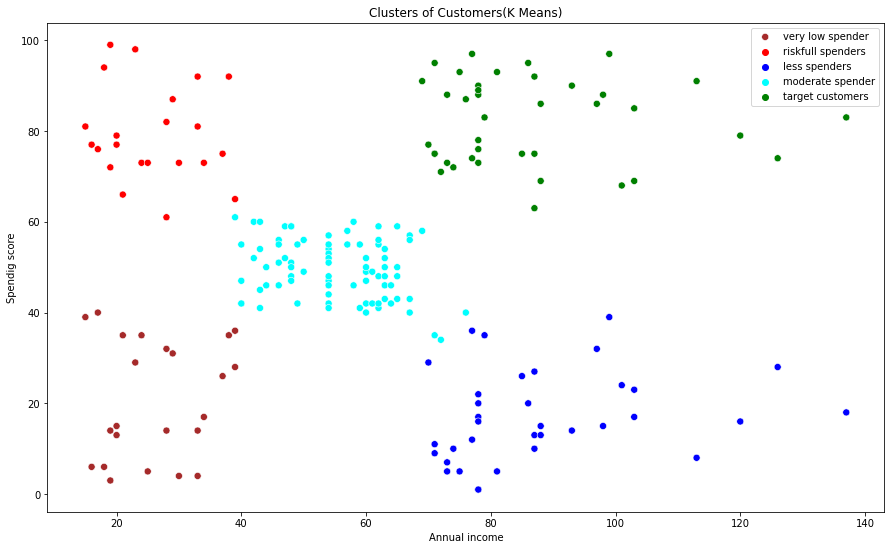

In [31]:
# Plotting the scatterplot of K means clustering
plt.figure(figsize=(15,9))
plt.title('Clusters of Customers(K Means)')
plt.xlabel("Annual income")
plt.ylabel("Spendig score")
sample_colours=['red','blue','cyan','green','brown']
sb.scatterplot(data=mall_num, x=x_km[:,0], y=x_km[:,1], hue=y_km,s=50,palette=sample_colours)
plt.legend(labels=['very low spender','riskfull spenders','less spenders','moderate spender','target customers']);

In [32]:
# Showing Spending scores & Annual Incomes of each clusters
for i in mall['Cluster(KMean)'].unique():
    print ('Cluster number : ',str(i))
    temp_df=mall[['Annual Income (k$)','Spending Score (1-100)','Cluster(KMean)']][mall['Cluster(KMean)']== i]
    print('Spending Scores : ', temp_df['Spending Score (1-100)'].unique())
    print(' Annual Income : ',temp_df['Annual Income (k$)'].unique())
    print(10*'===========')

Cluster number :  Very Low Spenders
Spending Scores :  [39  6 40  3 14 15 13 35 29  5 32 31  4 17 26 36 28]
 Annual Income :  [15 16 17 18 19 20 21 23 24 25 28 29 30 33 34 37 38 39]
Cluster number :  Riskfull Spenders
Spending Scores :  [81 77 76 94 72 99 79 66 98 73 82 61 87 92 75 65]
 Annual Income :  [15 16 17 18 19 20 21 23 24 25 28 29 30 33 34 37 38 39]
Cluster number :  Moderate Spender
Spending Scores :  [61 55 47 42 52 60 54 45 41 50 46 51 56 59 48 49 53 44 57 58 40 43 35 34]
 Annual Income :  [39 40 42 43 44 46 47 48 49 50 54 57 58 59 60 61 62 63 64 65 67 69 71 72
 76]
Cluster number :  Target Customers
Spending Scores :  [91 77 95 75 71 88 73 72 93 87 97 74 90 76 89 78 83 63 92 86 69 68 85 79]
 Annual Income :  [ 69  70  71  72  73  74  75  76  77  78  79  81  85  86  87  88  93  97
  98  99 101 103 113 120 126 137]
Cluster number :  Less Spenders
Spending Scores :  [29 11  9  5  7 10 12 36 22 17 20 16  1 35 26 27 13 15 14 32 39 24 23  8
 28 18]
 Annual Income :  [ 70  71  73

### Recomendations

* 1.Targeted Customers : Target those customers who earns more & spend more also. They are the ideal one to spend more on festive season sales.
* 2.Moderate Spenders : Consider those customers who earns moderate & spend moderate also. Their is a chance that they can spend a bit more on the festive season sales.
* 3.Less Spenders : You can Consider those customers also who earns more but spend less. Their is a chance that they can spend a bit more on the festive season sales.
* 4.Riskful Spenders : Avoid the customers who earns less but spends more cause their is always a risk that they use their credit cards to pay the bills.
* 5.Very low Spenders : Avoid the customers who earns less but spends less also.